In [41]:
import numpy
import os
import re
import binascii
from time import time


In [42]:
documents = []
for root, dirs, files in os.walk("C:/Users/shohidul/Desktop/awards_2002"):
    for file in files:
        if file.endswith(".txt"):
            with open(os.path.join(root, file),"rt") as f:
                text = [line.strip() for line in f.readlines()]
                documents.append(text)

In [43]:
### Calculate TF-IDF scores on a corpus

import json
from sklearn.feature_extraction.text import TfidfVectorizer

#with open("fname",, encoding="utf-8" "rt") as f:
    #documents = [line.strip() for line in f.readlines()]

# Set parameters and initialize
tfidf_vectorizer = TfidfVectorizer(min_df=2, use_idf=True,sublinear_tf=True, max_df=1.0, max_features=20000,lowercase = False,smooth_idf=True)
# Tip: the vectorizer also supports extracting n-gram features (common short sequences of words), which may be more descriptive but also much less frequent

# Calcualate term-document matrix with tf-idf scores
tfidf_matrix = tfidf_vectorizer.fit_transform(documents[0])
# Check matrix shape
tfidf_matrix.toarray().shape # N_docs x N_terms

(113, 82)

In [44]:
# Inspect terms in vocabulary
print(tfidf_vectorizer.get_feature_names()[:10])
print(tfidf_vectorizer.get_feature_names()[-10:])

['2002', 'Award', 'Chow', 'Conjecture', 'DMS', 'Date', 'Estimated', 'For', 'Hodge', 'Integral']
['the', 'theory', 'this', 'to', 'using', 'varieties', 'variety', 'which', 'with', 'world']


In [45]:
#tfidf_matrix[:,tfidf_vectorizer.get_feature_names().index('record')].toarray() # Get doc vector for term

In [46]:
## Inspect document frequencies (counts) of terms

from collections import Counter
terms_in_docs = tfidf_vectorizer.inverse_transform(tfidf_matrix)
token_counter = Counter()
for terms in terms_in_docs:
    token_counter.update(terms)

for term, count in token_counter.most_common(20):
    print("%d\t%s" % (count, term))

28	the
23	of
13	is
13	to
12	algebraic
8	Chow
8	geometry
8	group
7	and
6	with
6	on
6	in
5	The
5	problem
5	problems
4	by
4	from
4	this
3	Award
3	This


# Tf-IDF is better than other for extracting features

In [47]:
 #Alternatively: Inspect IDF values directly
#print(sorted(zip(tfidf_vectorizer.get_feature_names(),tfidf_vectorizer._tfidf.idf_),key=lambda x:x[1])[:20])

In [48]:
#features = tfidf_vectorizer.get_feature_names()
#features

In [49]:
## Inspect top terms per document

features = tfidf_vectorizer.get_feature_names()
for doc_i in range(5):
    print("\nDocument %d, top terms by TF-IDF" % doc_i)
    for term, score in sorted(list(zip(features,tfidf_matrix.toarray()[doc_i])), key=lambda x:-x[1])[:5]:
        print("%.2f\t%s" % (score, term))


Document 0, top terms by TF-IDF
0.81	Chow
0.59	of
0.00	2002
0.00	Award
0.00	Conjecture

Document 1, top terms by TF-IDF
1.00	Award
0.00	2002
0.00	Chow
0.00	Conjecture
0.00	DMS

Document 2, top terms by TF-IDF
0.71	DMS
0.71	NSF
0.00	2002
0.00	Award
0.00	Chow

Document 3, top terms by TF-IDF
0.00	2002
0.00	Award
0.00	Chow
0.00	Conjecture
0.00	DMS

Document 4, top terms by TF-IDF
0.00	2002
0.00	Award
0.00	Chow
0.00	Conjecture
0.00	DMS


In [50]:
print(tfidf_matrix.toarray())

[[0.         0.         0.81043796 ... 0.         0.         0.        ]
 [0.         1.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.54691413 0.        ]]


In [51]:
print("Document vector length:", tfidf_matrix.shape[1])
for i in range(5):
    print("Non-zero dimensions for document %d: %d" % (i, len([x for x in tfidf_matrix.toarray()[i] if x > 0])))

Document vector length: 82
Non-zero dimensions for document 0: 2
Non-zero dimensions for document 1: 1
Non-zero dimensions for document 2: 2
Non-zero dimensions for document 3: 0
Non-zero dimensions for document 4: 0


In [52]:
print("Sample word:", features[0])
print("Occurs in %d documents" % len([x for x in tfidf_matrix.toarray()[:][12] if x > 0]))
print("out of %d documents" % len(tfidf_matrix.toarray()))

Sample word: 2002
Occurs in 1 documents
out of 113 documents


In [53]:
# We use a subset of the documents in clustering for faster calculation and easier interpretation of results
matrix_sample = tfidf_matrix[:100]

In [54]:
from sklearn.cluster import KMeans

# Do clustering
km = KMeans(n_clusters=30, random_state=123, verbose=0)
km.fit(matrix_sample)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=30, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=123, tol=0.0001, verbose=0)

In [55]:
import heapq, numpy as np

# Custom function to print top keywords for each cluster
def print_clusters(matrix, clusters, n_keywords=10):
    for cluster in range(min(clusters), max(clusters)+1):
        cluster_docs = [i for i, c in enumerate(clusters) if c == cluster]
        print("Cluster: %d (%d docs)" % (cluster, len(cluster_docs)))
        
        # Keep scores for top n terms
        new_matrix = np.zeros((len(cluster_docs), matrix.shape[1]))
        for cluster_i, doc_vec in enumerate(matrix[cluster_docs].toarray()):
            for idx, score in heapq.nlargest(n_keywords, enumerate(doc_vec), key=lambda x:x[1]):
                new_matrix[cluster_i][idx] = score

        # Aggregate scores for kept top terms
        keywords = heapq.nlargest(n_keywords, zip(new_matrix.sum(axis=0), features))
        print(', '.join([w for s,w in keywords]))
        print()

In [56]:
km.labels_

array([ 6,  1,  0,  0,  0, 14,  0,  0,  1,  1,  0, 15, 15, 14,  3,  0,  3,
        0,  0,  0,  0,  0, 13,  0, 13,  0,  4, 22, 18,  0, 12,  0,  8, 27,
       28, 16,  0,  8, 10,  8, 24, 24,  9,  0,  0, 18,  6,  0,  8, 18, 16,
        9,  7, 11,  0, 25,  0,  0,  0,  4, 18, 26,  7, 11,  0, 29, 21,  0,
       21,  5,  0,  0,  0,  0,  5,  0,  4, 23, 17, 17,  4,  0, 12,  9,  0,
        2, 20,  6, 19,  0,  0, 20,  0, 23,  6,  0,  0, 19,  0,  0])

In [57]:
print_clusters(matrix_sample, km.labels_)

Cluster: 0 (40 docs)
and, of, the, problems, algebraic, frequently, with, that, an, current

Cluster: 1 (3 docs)
Award, world, with, which, variety, varieties, using, to, this, theory

Cluster: 2 (1 docs)
with, on, world, which, variety, varieties, using, to, this, theory

Cluster: 3 (2 docs)
Estimated, world, with, which, variety, varieties, using, to, this, theory

Cluster: 4 (4 docs)
geometry, tendency, algebraic, from, This, the, to, is, be, with

Cluster: 5 (2 docs)
extent, world, with, which, variety, varieties, using, to, this, theory

Cluster: 6 (4 docs)
aspects, of, Chow, problem, the, from, world, with, which, variety

Cluster: 7 (2 docs)
relationship, the, world, with, which, variety, varieties, using, to, this

Cluster: 8 (4 docs)
group, is, Chow, the, have, of, algebraic, to, subgroup, studied

Cluster: 9 (3 docs)
to, difficult, and, the, world, with, which, variety, varieties, using

Cluster: 10 (1 docs)
While, world, with, which, variety, varieties, using, to, this, theo

cluster4 describes about algebra mathematics whereas cluster9 is very bad to describe

Key words of clusters are: and, of, the, problems, algebraic, frequently, with, that, an, current

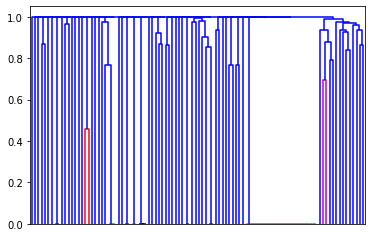

In [58]:
### Hierarchical clustering (alternative approach)

from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

Z = linkage(matrix_sample.todense())
_ = dendrogram(Z, no_labels=True) # Plot dentrogram chart

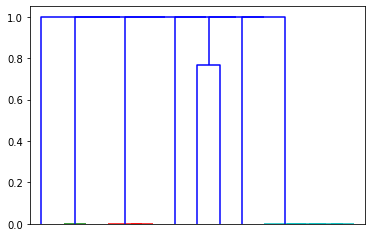

In [59]:
# View dendrogram for subset
Z_ = linkage(matrix_sample.todense()[:15])
_ = dendrogram(Z_, no_labels=True) # Plot dentrogram chart

In [60]:
## Get flat clusters from cluster hierarchy

#clusters = fcluster(Z, 50, criterion='maxclust') # Create fix number of flat clusters
clusters = fcluster(Z, .99, criterion='distance') # Create flat clusters by distance threshold

print_clusters(matrix_sample, clusters)

Cluster: 1 (2 docs)
world, into, mathematics, task, of, the, with, which, variety, varieties

Cluster: 2 (2 docs)
extent, world, with, which, variety, varieties, using, to, this, theory

Cluster: 3 (2 docs)
Integral, Hodge, Conjecture, has, It, some, The, in, is, world

Cluster: 4 (2 docs)
singular, between, and, group, Chow, the, cohomology, world, with, which

Cluster: 5 (5 docs)
on, with, which, that, world, variety, varieties, using, to, this

Cluster: 6 (2 docs)
Estimated, world, with, which, variety, varieties, using, to, this, theory

Cluster: 7 (2 docs)
June, Date, 2002, world, with, which, variety, varieties, using, to

Cluster: 8 (3 docs)
Award, world, with, which, variety, varieties, using, to, this, theory

Cluster: 9 (3 docs)
While, processes, infinite, which, the, world, with, variety, varieties, using

Cluster: 10 (2 docs)
problems, in, mathematics, to, of, world, with, which, variety, varieties

Cluster: 11 (2 docs)
relationship, the, world, with, which, variety, variet

#here k-mean clustering method is better than hierarchy clustering method
#because in hierarchy we had to choose threshold

In [61]:
## Topic modeling demo
#!pip3 install gensim

# Fast and simple tokenization
new_vectorizer = TfidfVectorizer()
word_tokenizer = new_vectorizer.build_tokenizer()
tokenized_text = [word_tokenizer(doc) for doc in documents[4]]
#tokenized_text
# Train LDA model
from gensim import corpora, models
dictionary = corpora.Dictionary(tokenized_text)
lda_corpus = [dictionary.doc2bow(text) for text in tokenized_text]
lda_model = models.LdaModel(lda_corpus, id2word=dictionary, num_topics=10)

2020-03-12 22:55:50,936 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2020-03-12 22:55:50,940 : INFO : built Dictionary(246 unique tokens: ['Competitive', 'Design', 'GOALI', 'Product', 'Robust']...) from 65 documents (total 421 corpus positions)
2020-03-12 22:55:50,944 : INFO : using symmetric alpha at 0.1
2020-03-12 22:55:50,946 : INFO : using symmetric eta at 0.1
2020-03-12 22:55:50,948 : INFO : using serial LDA version on this node
2020-03-12 22:55:50,951 : INFO : running online (single-pass) LDA training, 10 topics, 1 passes over the supplied corpus of 65 documents, updating model once every 65 documents, evaluating perplexity every 65 documents, iterating 50x with a convergence threshold of 0.001000
2020-03-12 22:55:50,952 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2020-03-12 22:55:51,083 : INFO : -13.024 per-word bound, 8327.4 perplexity estimate based on a held-out corpus o

In [62]:
# Inspect topics
for i, topic in lda_model.show_topics(num_words=10, formatted=False):
    print("Topic", i)
    for term, score in topic:
        print("%.4f\t%s" % (score,term))
    print()

Topic 0
0.0558	market
0.0293	and
0.0293	design
0.0293	alternatives
0.0293	the
0.0293	demand
0.0293	stage
0.0293	In
0.0293	module
0.0293	second

Topic 1
0.0444	of
0.0396	and
0.0394	to
0.0270	robust
0.0183	set
0.0183	this
0.0183	College
0.0183	preferences
0.0183	Park
0.0183	MD

Topic 2
0.0495	the
0.0180	engineering
0.0180	and
0.0180	for
0.0180	uncertainties
0.0180	into
0.0180	to
0.0180	taking
0.0180	learn
0.0180	provide

Topic 3
0.0433	design
0.0433	alternative
0.0293	product
0.0293	of
0.0293	to
0.0154	and
0.0154	single
0.0154	practices
0.0154	selection
0.0154	methodology

Topic 4
0.0293	current
0.0293	William
0.0293	2002
0.0293	Co
0.0293	Principal
0.0293	Date
0.0293	Investigator
0.0293	Spencer
0.0293	Start
0.0293	June

Topic 5
0.0587	in
0.0305	the
0.0298	selection
0.0298	design
0.0298	product
0.0202	for
0.0202	are
0.0202	and
0.0202	DMI
0.0202	Award

Topic 6
0.0527	and
0.0386	in
0.0202	to
0.0202	this
0.0202	objective
0.0202	The
0.0202	research
0.0202	is
0.0202	uncontrollable
0.0202	frame

In [63]:
# Inspect topics
for i, topic in lda_model.show_topics(num_words=50, formatted=False):
    print("Topic", i)
    printed_terms = 0
    for term, score in topic:
        if printed_terms >= 10:
            break
        elif term in "the of and to for in or The is be may an a with at are on by as from can".split():
            continue
        printed_terms += 1
        print("%.4f\t%s" % (score,term))
    print()

Topic 0
0.0558	market
0.0293	design
0.0293	alternatives
0.0293	demand
0.0293	stage
0.0293	In
0.0293	module
0.0293	second
0.0292	Advantage
0.0292	Abstract

Topic 1
0.0270	robust
0.0183	set
0.0183	this
0.0183	College
0.0183	preferences
0.0183	Park
0.0183	MD
0.0138	will
0.0096	profit
0.0096	generate

Topic 2
0.0180	engineering
0.0180	uncertainties
0.0180	into
0.0180	taking
0.0180	learn
0.0180	provide
0.0180	Principal
0.0180	Investigator
0.0180	product
0.0180	Allen

Topic 3
0.0433	design
0.0433	alternative
0.0293	product
0.0154	single
0.0154	practices
0.0154	selection
0.0154	methodology
0.0154	evaluation
0.0154	research
0.0154	generation

Topic 4
0.0293	current
0.0293	William
0.0293	2002
0.0293	Co
0.0293	Principal
0.0293	Date
0.0293	Investigator
0.0293	Spencer
0.0293	Start
0.0293	June

Topic 5
0.0298	selection
0.0298	design
0.0298	product
0.0202	DMI
0.0202	Award
0.0106	engineering
0.0106	each
0.0106	two
0.0106	involved
0.0106	account

Topic 6
0.0202	this
0.0202	objective
0.0202	research
0.

lda allocate the features to the group much more bethher tha k-means and hierarchy clustering

In [64]:
from sklearn.metrics.pairwise import cosine_similarity

print("Similar terms to:", features[80])
# Get most similar terms according to the cosine similarity of their vectors (columns in the term-document matrix)
heapq.nlargest(10, zip(cosine_similarity(tfidf_matrix[:,81].todense().T, tfidf_matrix.todense().T)[0], features))

Similar terms to: with


[(0.9999999999999999, 'world'),
 (0.9999999999999999, 'into'),
 (0.5029713360043134, 'mathematics'),
 (0.3551236073883025, 'task'),
 (0.11699697043571157, 'of'),
 (0.10912121868680959, 'the'),
 (0.0, 'with'),
 (0.0, 'which'),
 (0.0, 'variety'),
 (0.0, 'varieties')]

In [65]:
#features

In [66]:
### Train word vectors

import gensim # Make sure you also have cython installed to accelerate computation!

import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

# Train word2vec model
vectors = gensim.models.Word2Vec(tokenized_text, size=10, window=5, min_count=1, workers=4)


2020-03-12 22:56:14,776 : WARNING : consider setting layer size to a multiple of 4 for greater performance
2020-03-12 22:56:14,778 : INFO : collecting all words and their counts
2020-03-12 22:56:14,779 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2020-03-12 22:56:14,781 : INFO : collected 246 word types from a corpus of 421 raw words and 65 sentences
2020-03-12 22:56:14,782 : INFO : Loading a fresh vocabulary
2020-03-12 22:56:14,786 : INFO : effective_min_count=1 retains 246 unique words (100% of original 246, drops 0)
2020-03-12 22:56:14,787 : INFO : effective_min_count=1 leaves 421 word corpus (100% of original 421, drops 0)
2020-03-12 22:56:14,793 : INFO : deleting the raw counts dictionary of 246 items
2020-03-12 22:56:14,794 : INFO : sample=0.001 downsamples 65 most-common words
2020-03-12 22:56:14,795 : INFO : downsampling leaves estimated 284 word corpus (67.6% of prior 421)
2020-03-12 22:56:14,798 : INFO : estimated required memory for 246 words an

In [67]:
# Inspect a word vector
vectors.wv["uncertainties"]

array([-0.01109278, -0.04341133, -0.04535558, -0.04294013,  0.0078231 ,
       -0.0369525 ,  0.03803169, -0.02085755,  0.00150449, -0.04307546],
      dtype=float32)

In [68]:
# Inspect words with vectors most similar to a given word
print("Most similar to:", 'uncertainties')
print(vectors.wv.most_similar('uncertainties'))
print()

2020-03-12 22:56:25,016 : INFO : precomputing L2-norms of word weight vectors


Most similar to: uncertainties
[('the', 0.7794070243835449), ('alternative', 0.7344417572021484), ('207425141', 0.7154356241226196), ('this', 0.6911375522613525), ('0200029', 0.6902447938919067), ('automation', 0.6342875957489014), ('robust', 0.6024630069732666), ('courses', 0.581272304058075), ('or', 0.5742402076721191), ('Title', 0.5704677700996399)]



In [69]:
# ...or combination or words (average vector)
print("Most similar to:", ['process', 'uncertainties'])
print(vectors.wv.most_similar(['process', 'uncertainties']))

Most similar to: ['process', 'uncertainties']
[('207425141', 0.7552006840705872), ('March', 0.7216493487358093), ('alternative', 0.7198970913887024), ('domains', 0.7008569240570068), ('this', 0.6458460092544556), ('Competitive', 0.6448894739151001), ('enhance', 0.6377053260803223), ('The', 0.6317423582077026), ('Based', 0.6279781460762024), ('automation', 0.5887629985809326)]


In [70]:
# Inspect cosine similarities between specific words
print(vectors.wv.similarity('technology', 'design'))
print(vectors.wv.similarity('technology', 'system'))
print(vectors.wv.similarity('technology', 'Award'))
print(vectors.wv.similarity('technology', 'time'))

0.36967823
-0.20987485
0.04629732
-0.30490637


In [71]:
## Test for analogies and syntactic regularities (when trained on a large and suitable corpus)

"""
# Man is to King as Woman is to ...
# vec(woman)+vec(king)-vec(man)
print(vectors.most_similar(['woman','king'], negative=['man']))
print()

# Fall is to Fell as Watch is to ...
print(vectors.most_similar(['wear','fell'], negative=['fall']))
print()

print(vectors.most_similar(['Moscow','France'], negative=['Paris']))
print()

print(vectors.most_similar(['London','France'], negative=['Paris']))
"""

"\n# Man is to King as Woman is to ...\n# vec(woman)+vec(king)-vec(man)\nprint(vectors.most_similar(['woman','king'], negative=['man']))\nprint()\n\n# Fall is to Fell as Watch is to ...\nprint(vectors.most_similar(['wear','fell'], negative=['fall']))\nprint()\n\nprint(vectors.most_similar(['Moscow','France'], negative=['Paris']))\nprint()\n\nprint(vectors.most_similar(['London','France'], negative=['Paris']))\n"

In [72]:
#features

In [73]:
# Ambiguous word vector examples

print("Most similar to:", 'design')
print(vectors.wv.most_similar('design'))
print()

# Are the below average vectors less ambiguous?
print("Most similar to:", ['date','design'])
print(vectors.wv.most_similar(['date','between']))
print()


Most similar to: design
[('learn', 0.9009382128715515), ('commonality', 0.8388251066207886), ('Org', 0.6409584283828735), ('generation', 0.6354787349700928), ('eng', 0.614288330078125), ('Technology', 0.6135535836219788), ('recommendations', 0.5996837615966797), ('decision', 0.5849766731262207), ('selection', 0.5335516333580017), ('Sponsor', 0.5313560962677002)]

Most similar to: ['date', 'design']


2020-03-12 22:57:00,314 : INFO : NumExpr defaulting to 4 threads.


KeyError: "word 'date' not in vocabulary"

In [74]:
import tensorflow_hub as hub
import tensorflow as tf


In [75]:
#!pip3 install tensorflow_hub tensorflow


#import tensorflow as tf

# Load ELMo model (takes a little while)
elmo = hub.Module("https://tfhub.dev/google/elmo/2", trainable=True)
def elmo_vectors(sents):
    embeddings = elmo(sents, signature="default", as_dict=True)["elmo"]
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        return sess.run(embeddings)
        #sess.run(tf.tables_initializer())
        #return average of ELMo features as sentence vector
        #return sess.run(tf.reduce_mean(embeddings,1))




2020-03-12 21:38:24,651 : INFO : Using C:\Users\shohidul\AppData\Local\Temp\tfhub_modules to cache modules.

In [76]:
# Get contextualized vectors for target word in different sentences

sents = """He wrote the play himself .
He did play with the kids .
His excuse didn't play well .
I saw the play with him .
He can play it by ear .""".split('\n')

target = 'play'

elmo_vecs = elmo_vectors(sents)
word_vecs = []
for i, sent in enumerate(sents):
    word_vecs.append(elmo_vecs[i][sent.split().index(target)])
    print("Sentence:", sent)
    print("Vector for '%s':" % target, word_vecs[-1])
    print()

print("Word vector size:", word_vecs[0].shape)

2020-03-12 22:58:21,686 : INFO : Saver not created because there are no variables in the graph to restore


Sentence: He wrote the play himself .
Vector for 'play': [-0.27192304  0.11288124 -0.3028859  ... -0.27269745  0.04967653
 -0.02397385]

Sentence: He did play with the kids .
Vector for 'play': [ 0.14034374  0.75535333  0.5396338  ... -0.26539382  0.25861102
  0.21444729]

Sentence: His excuse didn't play well .
Vector for 'play': [-0.08138274  0.13417737  0.41862282 ... -0.44263023  0.30514812
  0.22920589]

Sentence: I saw the play with him .
Vector for 'play': [-0.42460334 -0.03112318 -0.01002066 ... -0.13054961 -0.06333602
  0.08011345]

Sentence: He can play it by ear .
Vector for 'play': [ 0.06018784  0.6498274   0.5208825  ...  0.14704973  0.02895296
 -0.08715162]

Word vector size: (1024,)


In [77]:
from sklearn.metrics.pairwise import cosine_similarity

vec_size = word_vecs[0].shape[0]
print("Similarities between '%s' vector in sentences:" % target)
for i in range(1, len(sents)):
    print("Sent 0-%d:" % i, cosine_similarity(word_vecs[0].reshape((1,vec_size)), 
                                              word_vecs[i].reshape((1,vec_size)))[0][0])

Similarities between 'play' vector in sentences:
Sent 0-1: 0.6555581
Sent 0-2: 0.60003823
Sent 0-3: 0.74981964
Sent 0-4: 0.5564689
